In [1]:
# !pip install pettingzoo

In [2]:
from pettingzoo.classic import connect_four_v3
import numpy as np
import matplotlib.pyplot as plt
import random as rd

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
from IPython.display import clear_output

# Using the PettingZoo environment

This notebook provides smalls chunks of code to get you started with the Connect4 project. You do not have to use this code in you final file, but you can if you wish to. 

In [3]:
env = connect_four_v3.env(render_mode="rgb_array")

env.reset()

# The main difference with the standard gym api is the way the environment is queried. The `step` method return `None`. 
# To get the data on the environment, use the `last` method
state, reward, terminated, truncated, info = env.last()

# Agents

Here are some implementations of trivial agents that you should be able to beat ultimately. 

In [4]:
class RandomPlayer:
    def __init__(self, rng=None):
        if rng is None:
            self.rng = np.random.default_rng()
        else:
            self.rng = rng

        self.name = "Random Player"

    def get_action(self, obs_mask, epsilon=None):
        return self.random_choice_with_mask(np.arange(7), obs_mask["action_mask"])

    def random_choice_with_mask(self, arr, mask):
        masked_arr = np.ma.masked_array(arr, mask=1 - mask)
        if masked_arr.count() == 0:
            return None
        return self.rng.choice(masked_arr.compressed())


In [5]:
class PlayLeftmostLegal:
    def __init__(self):
        self.name = "Left Player"

    def get_action(self, obs_mask, epsilon=None):
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                return i
        return None


# Running a game


The following function runs a full game between the two agents. 

In [6]:
def play_game(env, agent0, agent1, display=False):
    done = False
    env.reset()
    obs, _, _, _, _ = env.last()
    while not done:
        for i, agent in enumerate([agent0, agent1]):
            action = agent.get_action(obs, epsilon=0)
            env.step(action)
            if display:
                clear_output(wait=True)
                plt.imshow(env.render())
                plt.show()
            obs, reward, terminated, _, _ = env.last()
            done = terminated
            if np.sum(obs["action_mask"]) == 0:
                if display: 
                    print('Draw')
                return 0.5
            if done:
                if display:
                    print(f"Player {i}: {agent.name} won")
                    print((obs['observation'][:, :, 0]- obs['observation'][:, :, 1]).shape)
                    print(obs['observation'][:, :, 0]- obs['observation'][:, :, 1])
                return i

In [7]:
def get_pts_up(board, l, c):
    '''
    Compte le nombre de pions alignés vers le haut,
    Les pionts sont ajoutés au score s'il y a une case vide au dessus du pion le plus haut
    '''
    if l <= 2:
        return 0
    lined_up = 1
    while board[l - lined_up, c ] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 1000
    if board[l - lined_up, c ] == 0:
        return lined_up
    return 0

def get_pts_right(board, l, c):
    '''
    Compte le nombre de pions alignés horizontlement,
    Les pionts sont ajoutés au score s'il y a une case vide à droite du pion le plus à droie ou a gauche du pion le plus à gauche
    '''
    if c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 1000
    if board[l, c + lined_up] == 0:
        right_possibility = 1
    if c != 0 :
        if board[l, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def get_pts_right_down(board, l, c):
    '''
    Compte le nombre de pions alignés en diagonale vert la droite et le bas,
    Les pionts sont ajoutés au score s'il y a une case vide pour agrandir la ligne
    '''
    if l >= 3 or c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l + lined_up, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 1000
    if board[l + lined_up, c + lined_up] == 0:
        right_possibility = 1
    if c != 0 and l != 0 :
        if board[l - 1, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def get_pts_right_up(board, l, c):
    '''
    Compte le nombre de pions alignés en diagonale vert la droite et le haut,
    Les pionts sont ajoutés au score s'il y a une case vide pour agrandir la ligne
    '''
    if l <= 2 or c >= 4:
        return 0
    right_possibility = 0
    left_possibility = 0
    lined_up = 1
    while board[l - lined_up, c + lined_up] == board[l, c]:
        lined_up += 1
        if lined_up == 4:
            return 1000
    if board[l - lined_up, c + lined_up] == 0 :
        right_possibility = 1
    if c != 0 and l != 5 :
        if board[l + 1, c - 1] == 0:
            left_possibility = 1
    return lined_up * (left_possibility + right_possibility)

def evaluate_position(board):
    ''' 
    Cette fonction  prend une grille de puissance 4 en entrée
    La fonction retourne un score
    Plus le score est élevé, plus le joueur 1 est en bonne position
    '''
    score_1 = 0
    score_2 = 0
    for l in range(6):
        for c in range(7):
            if board[l,c] == 1:
                score_1 = score_1 + get_pts_up(board, l, c) + get_pts_right(board, l, c) + get_pts_right_down(board, l, c) + get_pts_right_up(board, l, c)
            if board[l,c] == -1:
                score_2 = score_2 + get_pts_up(board, l, c) + get_pts_right(board, l, c) + get_pts_right_down(board, l, c) + get_pts_right_up(board, l, c)
    #print('Score de 1 :', score_1)
    #print('Score de 2 :', score_2)
    return score_1 - score_2


In [10]:
board = np.array([[0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0, 0]])

evaluate_position(board)


4

In [11]:
def new_move(board, i):
    layer = 5
    bottom = board[layer,i]
    while bottom !=0 and layer>0 :
        #print(i,"on monte d'un cran")
        layer-=1
        bottom = board[layer,i]
    if layer == 0 and bottom !=0:
        print("on est tout en haut y a pas de place")
    else :
        new_board = board.copy()
        new_board[layer,i] = 1
    return new_board

def get_move_score(board, i):
    board_after_i = new_move(board, i)
    a = evaluate_position(board_after_i)
    return a


In [12]:
def is_blunder(board, i):
    'This function check if tthere is a win in one move for the opponent'
    is_blunder = False
    board_after_i = new_move(board, i)
    board_after_i_for_opponent = - board_after_i
    for i in range(7):
        if board_after_i_for_opponent[0,i] == 0:
            if get_move_score(board_after_i_for_opponent, i) > 500 :
                is_blunder = True
    return is_blunder

def get_move_score_with_blunder(board, i, random_percentage):
    if is_blunder(board, i):
        return -1000
    if rd.random() < random_percentage:
        return - 10
    return get_move_score(board, i)

In [13]:
def best_score_for_opponent(board, i):
    board_after_i = new_move(board, i)
    board_after_i_for_opponent = - board_after_i
    best_score = - 10000
    for i in range(7):
        if board_after_i_for_opponent[0,i] == 0:
            move_score = get_move_score(board_after_i_for_opponent, i)
            if move_score > best_score:
                best_score = move_score
    return best_score

def get_move_score_depth_2(board, i, random_percentage):
    if rd.random() < random_percentage:
        return - 10
    return get_move_score(board, i) - best_score_for_opponent(board, i)

In [17]:
class MalynxWithoutBlunder:
    def __init__(self, random_percentage = 0):
        self.name = "Malynx Avoiding Blunder"
        self.random_percentage = random_percentage
    def get_action(self, obs_mask, epsilon=None):
        if np.sum(obs_mask['observation']) == 0:
            return 3
        board = obs_mask['observation'][:, :, 0]- obs_mask['observation'][:, :, 1]
        best_move_score = - 10000
        best_move = 10
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                move_score = get_move_score_with_blunder(board, i, self.random_percentage)
                if move_score == best_move_score and rd.random() < 0.5:
                    best_move = i
                if move_score > best_move_score:
                    best_move_score = move_score
                    best_move = i
        return best_move

In [18]:
class MalynxDeep:
    def __init__(self, random_percentage = 0):
        self.name = "Malynx Deep"
        self.random_percentage = random_percentage
    def get_action(self, obs_mask, epsilon=None):
        if np.sum(obs_mask['observation']) == 0:
            return 3
        board = obs_mask['observation'][:, :, 0]- obs_mask['observation'][:, :, 1]
        best_move_score = - 10000
        best_move = 10
        for i, legal in enumerate(obs_mask["action_mask"]):
            if legal:
                move_score = get_move_score_depth_2(board, i, self.random_percentage)
                if move_score == best_move_score and rd.random() < 0.5:
                    best_move = i
                if move_score > best_move_score:
                    best_move_score = move_score
                    best_move = i
        return best_move

In [32]:
from malynx_avoiding_blunder.py import MalynxAvoidingBlunder

ImportError: cannot import name 'MalynxAvoidingBlunder' from 'malynx_avoiding_blunder' (/Users/Mathian/Documents/IA/RL/project/Puissance_Quatre_RL/malynx_avoiding_blunder.py)

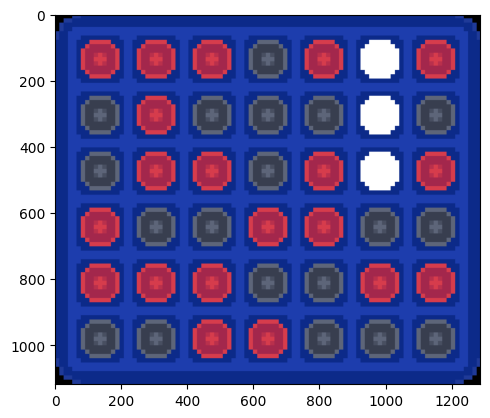

Player 0: Malynx Deep won
(6, 7)
[[ 1  1  1 -1  1  0  1]
 [-1  1 -1 -1 -1  0 -1]
 [-1  1  1 -1  1  0  1]
 [ 1 -1 -1  1  1 -1 -1]
 [ 1  1  1 -1 -1  1  1]
 [-1 -1  1  1 -1 -1 -1]]


0

In [19]:
agent0 = MalynxDeep(0.1)
agent1 = MalynxWithoutBlunder(0.1)

play_game(env, agent0, agent1, display=True)

Malynx Deep  starts


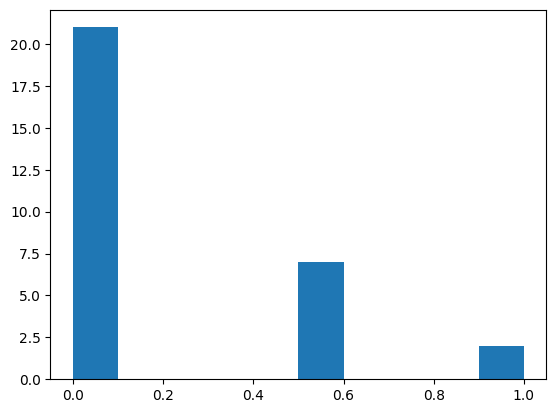

Win percentage of  Malynx Deep  :  81 %
Malynx Avoiding Blunder  starts


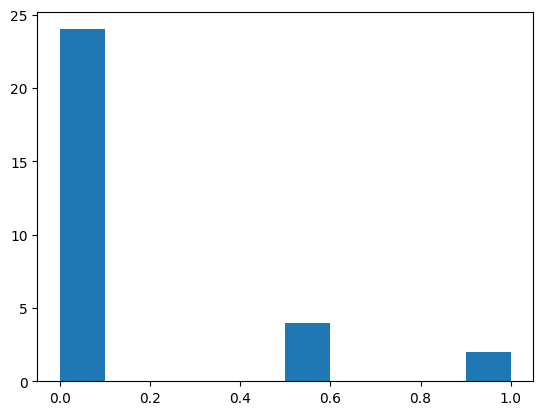

Win percentage of  Malynx Avoiding Blunder  :  86 %


In [25]:
print(agent0.name, 'starts')
L = [play_game(env, agent0, agent1, display=False) for _ in range(30)]
plt.hist(L)
plt.show()
print('\nWin percentage of ', agent0.name, ' : ', int(100*(len(L) - sum(L)) /len(L)), '%')

print(agent1.name, 'starts')
L = [play_game(env, agent1, agent0, display=False) for _ in range(30)]
plt.hist(L)
plt.show()
print('\nWin percentage of', agent1.name, ' : ', int(100*(len(L) - sum(L)) /len(L)), '%')


# Emulating a Gym environment

If we fix the opposite policy, the game from the point of view of the agent is equivalent to a Gym environment. The following class implements this simulation. Then any algorithm that would work in a gym environment with the same observations will work here. 

Note that we implemented the possibility to be the first or the second player. 

In [ ]:
class EnvAgainstPolicy: 
    def __init__(self, env, policy, first_player=True):
        self.policy = policy
        self.env = env
        self.first_player = first_player
        self.reset()

    def step(self, action):
        self.env.step(action)
        obs, reward, terminated, _, _ = self.env.last()
        if terminated: 
            self.last_step = obs, reward, True, False, {}
        else: 
            action = self.policy.get_action(obs)
            self.env.step(action)
            obs, reward, terminated, _, _ = self.env.last()
            self.last_step = obs, -reward, terminated, False, {}
        return self.last_step

    def reset(self):
        self.env.reset()
        if not(self.first_player): 
            obs, _, _, _, _ = self.env.last()
            action = self.policy.get_action(obs)
            self.env.step(action)

        self.last_step = self.env.last()
        return self.last_step

    def last(self):
        return self.last_step

# Evaluating an agent against a fixed policy: 

Using the environment above, we can evaluate the agent against this fixed policy. 

In [ ]:
def eval_against_policy(env, agent, policy, N_episodes=10, first_player=True):
    eval_env = EnvAgainstPolicy(env, policy, first_player=first_player)
    results = []
    for _ in range(N_episodes):
        done = False
        eval_env.reset()
        obs, _, _, _, _ = eval_env.last()
        while not done:
            action = agent.get_action(obs, epsilon=0)
            eval_env.step(action)
            obs, reward, done, _, _ = eval_env.last()
        results.append(reward)
    return results

We can see that if both players play randomly, there is a small but significant advantage to the first player. 

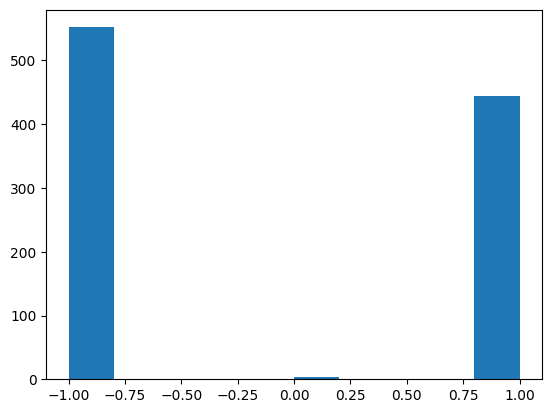

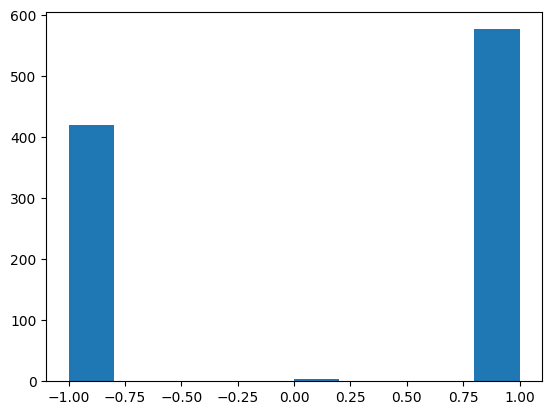

In [24]:
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=False))
plt.show()
plt.hist(eval_against_policy(env, RandomPlayer(), RandomPlayer(), N_episodes=1000, first_player=True))
plt.show()

# Your turn 

Try to build a decent agent. Be creative! You can try any idea that you have: the grade is not about performance of the agent, but more about illustrating phenomena happening in Reinforcement Learning for turn-based games. It's okay to 'help' the agent in any way, as long as it follows the ideas of RL (i.e., as long as there is some learning involved).


